[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Botiy/TerraTriad/blob/main/AirbusShipdetection.ipynb)

# Loading data and visualizing
## **Chosen method:** downloading the kaggle competition to the /content folder, then unzipping it
## **Important:** (this requires approximately 60GB temporarily) zip folder can be deleted after the unpacking, to regain 30GB of space

Authentication - here the kaggle.json file needs to be uploaded

In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"horvthbotondtrylvw","key":"809fb1d01438b6e4dc65d2324c14c1f7"}'}

Uploading and using authorization data

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading the project to the /content folder

In [3]:
!kaggle competitions download -c airbus-ship-detection -p /content

100% 28.6G/28.6G [06:03<00:00, 112MB/s] 
100% 28.6G/28.6G [06:03<00:00, 84.4MB/s]


Unzipping (the zip folder can then be safely deleted)

In [4]:
!unzip /content/airbus-ship-detection.zip -d /content/airbus-ship-detection


A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: /content/airbus-ship-detection/train_v2/f9775b70e.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f977a470c.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9780bfaf.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9782bdfe.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9785ca49.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9785e462.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97a719d5.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97afa376.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97b85e3e.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97bd0b11.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97bd6b80.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97bfb1b2.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97c8cbbe.jpg  
  inflating: /content/airbus-ship-detection/train_v2

Checking whether the necessary elements are present

In [5]:
!ls /content/airbus-ship-detection

sample_submission_v2.csv  test_v2  train_ship_segmentations_v2.csv  train_v2


Sample usage - we draw 3 images from both the train_v2 and test_v2 folders

Displaying first 3 images from the train_v2 folder:


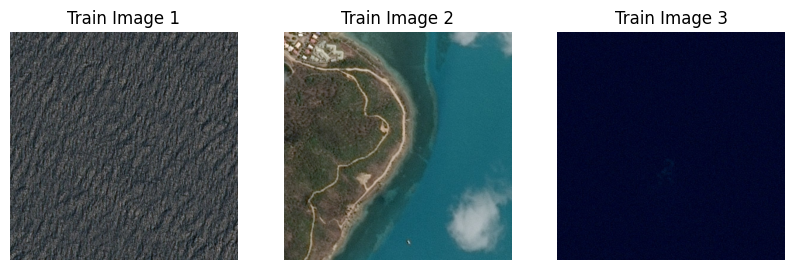

Displaying first 3 images from the test_v2 folder:


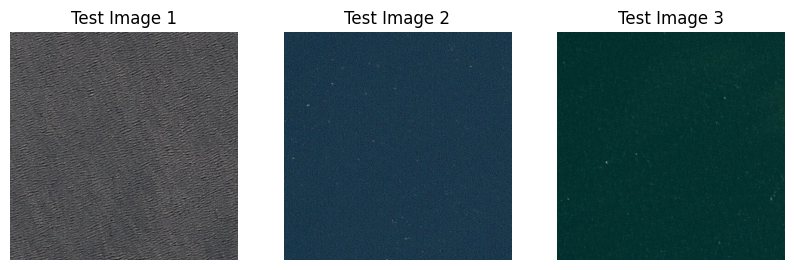

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# path of the train and test folders
train_folder = '/content/airbus-ship-detection/train_v2/'
test_folder = '/content/airbus-ship-detection/test_v2/'

# Get the first 3 image filenames from both train and test directories
train_images = os.listdir(train_folder)[:3]
test_images = os.listdir(test_folder)[:3]

# Function to display images
def show_images(image_folder, image_list, title):
    plt.figure(figsize=(10,5))
    for idx, image_file in enumerate(image_list):
        img_path = os.path.join(image_folder, image_file)
        img = Image.open(img_path)
        plt.subplot(1, 3, idx+1)
        plt.imshow(img)
        plt.title(f'{title} {idx+1}')
        plt.axis('off')  # Turn off axis labels for a cleaner look
    plt.show()

# Show first 3 train images
print("Displaying first 3 images from the train_v2 folder:")
show_images(train_folder, train_images, 'Train Image')

# Show first 3 test images
print("Displaying first 3 images from the test_v2 folder:")
show_images(test_folder, test_images, 'Test Image')


Count images based on the training file data and showing the head of the dataframe

In [7]:
import pandas as pd

# Load the annotations file
csv_path = '/content/airbus-ship-detection/train_ship_segmentations_v2.csv'
df = pd.read_csv(csv_path)

# Check for missing annotations
print(f"Number of images without ships: {df['EncodedPixels'].isna().sum()}")
print(f"Number of images with ships: {df['EncodedPixels'].notna().sum()}")

# Show the first few rows of the dataframe
df.head()


Number of images without ships: 150000
Number of images with ships: 81723


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Splitting the data and shuffling it

In [8]:
import random

# Shuffle the dataset (frac=1 means that it will keep all rows)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Determine the sizes for each split
total_images = len(df_shuffled)
train_size = int(0.8 * total_images)  # 80% for training
val_size = int(0.1 * total_images)    # 10% for validation
test_size = total_images - train_size - val_size  # Remaining for test

train_df = df_shuffled[:train_size]          # First 80% for training
val_df = df_shuffled[train_size:train_size + val_size]  # Next 10% for validation
test_df = df_shuffled[train_size + val_size:]  # Last 10% for testing

# Print the size of each set
print(f"Total images: {total_images}")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Total images: 231723
Training set size: 185378
Validation set size: 23172
Test set size: 23173


Checking image size

In [9]:
from PIL import Image
img = Image.open(os.path.join(train_folder, train_images[0]))
print(f"Image size: {img.size}")

Image size: (768, 768)


Converting RLE format to masked format

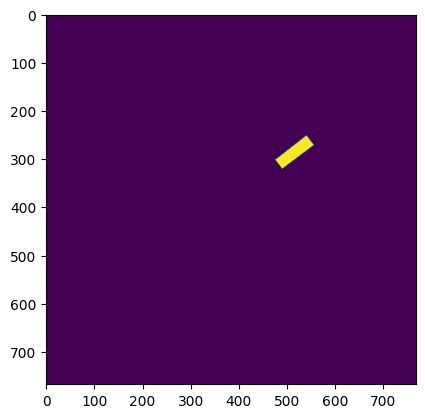

In [10]:
import numpy as np

# Convert RLE to mask
def rle_decode(mask_rle, shape=(768, 768)):
    if pd.isnull(mask_rle):  # Check if the RLE is NaN
        return np.zeros(shape, dtype=np.uint8)  # Return an empty mask if there's no ship

    s = mask_rle.split()  # Split the string into RLE parts
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for start, end in zip(starts, ends):
        img[start:end] = 1

    return img.reshape(shape).T  # Reshape and transpose to get the correct mask orientation

# Test on a single image
mask_rle = df.iloc[30]['EncodedPixels']
mask = rle_decode(mask_rle)
plt.imshow(mask)
plt.show()

Custom dataset class using pytorch

In [11]:
#img

In [12]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms



class AirbusShipDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): A dataframe with ImageId and EncodedPixels (ship mask).
            image_dir (str): Directory where the images are stored.
            transform (callable, optional): Optional transform to be applied on the image and mask.
        """
        self.ships_frame = dataframe
        self.image_dir = image_dir
        self.transform = transform

        !mkdir /content/airbus-ship-detection/tmp

    def __len__(self):
        return len(self.ships_frame)

    def __getitem__(self, idx):
        # Get the image name
        img_name = self.ships_frame.iloc[idx, 0]
        tmp_file_path = f"/content/airbus-ship-detection/tmp/{img_name}"
        !unzip -p /content/airbus-ship-detection.zip train_v2/{img_name} > {tmp_file_path}
        # img_name = os.path.join(self.image_dir, self.ships_frame.iloc[idx, 0])
        # Load the image using PIL
        image = Image.open(tmp_file_path)

        # Get the RLE mask and decode it
        mask_rle = self.ships_frame.iloc[idx, 1]
        mask = rle_decode(mask_rle)

        # Convert image and mask to tensors
        image = np.array(image)

        if self.transform:
            # Apply transformations to both image and mask
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Convert to PyTorch tensors
        image = torch.from_numpy(image).float().div(255.0).permute(2, 0, 1)  # Change to [C, H, W] format
        # image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image) # Normalize the image for future stable learning
        mask = torch.from_numpy(mask).float().unsqueeze(0)         # Add channel dimension to mask

        return {'image': image, 'mask': mask}

Display masked image using a colormap

<ipython-input-13-ba6a347f199f>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 256)  # Start with a 'viridis' colormap


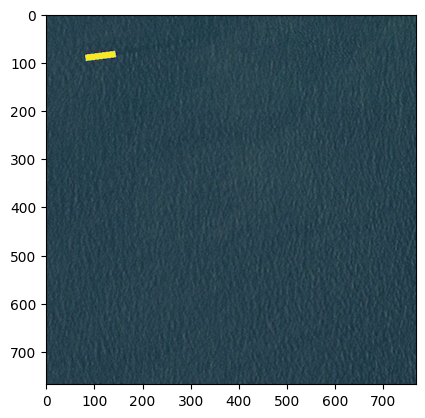

In [13]:
from matplotlib.colors import ListedColormap

dataset = AirbusShipDataset(df_shuffled, train_folder, transform=None)
datapoint = dataset[5228]


cmap = plt.cm.get_cmap('viridis', 256)  # Start with a 'viridis' colormap
new_cmap = cmap(np.arange(256))
new_cmap[0, :] = [1, 1, 1, 0]  # Set the first color to be transparent
new_cmap = ListedColormap(new_cmap)

plt.imshow(datapoint['image'].numpy().transpose(1, 2, 0))
plt.imshow(datapoint['mask'].numpy().transpose(1, 2, 0), cmap=new_cmap)

Testing, how SAM integration would look like

In [14]:

!pip install \ 'git+https://github.com/facebookresearch/segment-anything.git'

!pip install -q roboflow supervision
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-c5ifc8tl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-c5ifc8tl
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=61cdc48c9ca4cc77042230cb1aee74cbaa89dc682c71f8d7437587c0780b8e43
  Stored in directory: /tmp/pip-ephem-wheel-cache-o6i8_tlu/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 10.6 MB/s eta 0:00:00


### Loading a SAM model

In [34]:
import torch
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import numpy as np
import cv2

# Load SAM model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"  # Choose model type based on your computational resources
CHECKPOINT_PATH = "/content/sam_vit_h_4b8939.pth"  # Path to SAM checkpoint

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

def generate_and_save_sam_mask(image_path, sam_model, mask_dir):

    os.makedirs(sam_mask_dir, exist_ok=True)
    # Load and convert image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate masks using SAM
    mask_generator = SamAutomaticMaskGenerator(sam_model)
    result = mask_generator.generate(image_rgb)

    # Save only the first mask as an example (customize if you need multiple masks)
    if result:
        mask = result[0]['segmentation']  # Extract the mask from the result

        # Define path for saving mask
        image_id = os.path.basename(image_path).split('.')[0]
        mask_path = os.path.join(mask_dir, f"{image_id}_sam_mask.npy")

        # Save the mask as .npy file
        np.save(mask_path, mask)
        return mask_path
    else:
        print(f"No mask generated for image: {image_path}")
        return None

# Define paths and directories
#example_image_path = os.path.join(train_folder, train_images[1])  # Path to one example image
sam_mask_dir = '/content/airbus-ship-detection/sam_masks'         # Directory to save masks

# Generate and save a single SAM mask for the example image
"""
mask_path = generate_and_save_sam_mask(example_image_path, sam, sam_mask_dir)

if mask_path:
    print(f"Mask saved at: {mask_path}")

    # Load and visualize the mask
    example_mask = np.load(mask_path)

    # Display the mask
    plt.imshow(example_mask, cmap='gray')
    plt.title("Generated SAM Mask")
    plt.axis('off')
    plt.show()
else:
    print(f"Mask generation failed for image: {example_image_path}")
"""


'\nmask_path = generate_and_save_sam_mask(example_image_path, sam, sam_mask_dir)\n\nif mask_path:\n    print(f"Mask saved at: {mask_path}")\n\n    # Load and visualize the mask\n    example_mask = np.load(mask_path)\n\n    # Display the mask\n    plt.imshow(example_mask, cmap=\'gray\')\n    plt.title("Generated SAM Mask")\n    plt.axis(\'off\')\n    plt.show()\nelse:\n    print(f"Mask generation failed for image: {example_image_path}")\n'

### Neural network for teaching

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        # Define contracting path
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        # Define expanding path
        self.decoder1 = self.conv_block(128, 64)
        self.decoder2 = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        # Decoding path
        dec1 = self.decoder1(F.interpolate(enc2, scale_factor=2, mode='bilinear', align_corners=False))
        dec2 = self.decoder2(dec1)
        return torch.sigmoid(dec2)  # Use sigmoid for binary mask output


In [52]:
# Assuming you have a DataFrame with the 20 images selected
small_train_df = train_df.sample(n=20, random_state=42).reset_index(drop=True)

# Loop through the images in small_train_df to generate masks
for idx, row in small_train_df.iterrows():
    img_name = row['ImageId']
    img_path = os.path.join(train_folder, img_name)

    # Generate and save SAM mask for the image
    mask_path = generate_and_save_sam_mask(img_path, sam, sam_mask_dir)

    if mask_path:
        print(f"Mask saved at: {mask_path}")
    else:
        print(f"Mask generation failed for image: {img_path}")

Mask saved at: /content/airbus-ship-detection/sam_masks/2ef9624d9_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/479c24467_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/1c012caad_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/376891d63_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/7c31a5b1d_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/96f74e01d_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/0fd06ee19_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/44b8c003c_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/26aeea39b_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/9027a5aec_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/74e0fc880_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_masks/dd0d35adb_sam_mask.npy
Mask saved at: /content/airbus-ship-detection/sam_ma

In [40]:
print("Mask directory:", sam_mask_dir)

Mask directory: /content/airbus-ship-detection/sam_masks


In [53]:
from torch.utils.data import Dataset

class AirbusShipDataset2(Dataset):
    def __init__(self, dataframe, image_dir, sam_mask_dir, transform=None):
        self.ships_frame = dataframe
        self.image_dir = image_dir
        self.sam_mask_dir = sam_mask_dir
        self.transform = transform

        # List to store valid images with corresponding masks
        self.valid_samples = []

        for idx in range(len(dataframe)):
            img_name = self.ships_frame.iloc[idx, 0]
            img_path = os.path.join(self.image_dir, img_name)

            # Mask filename convention
            expected_mask_name = f"{img_name.split('.')[0]}_sam_mask.npy"
            mask_path = os.path.join(self.sam_mask_dir, expected_mask_name)

            # Check if both image and mask exist
            if os.path.exists(img_path) and os.path.exists(mask_path):
                self.valid_samples.append((img_path, mask_path))
            else:
                print(f"Warning: Image or mask not found for image: {img_name}")

        print(f"Found {len(self.valid_samples)} images with masks.")

    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        i_path, m_path = self.valid_samples[idx]

        # Load and preprocess image
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        # Load mask
        mask = np.load(m_path)

        # Apply transformations if defined
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Convert to tensors
        image = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
        mask = torch.from_numpy(mask).float().unsqueeze(0)

        return {'image': image, 'mask': mask}

In [54]:
print(f"Expected Image Path: {img_path}, Expected Mask Path: {mask_path}")

Expected Image Path: /content/airbus-ship-detection/train_v2/d494daa85.jpg, Expected Mask Path: /content/airbus-ship-detection/sam_masks/d494daa85_sam_mask.npy


In [47]:
print("Generated masks:", os.listdir(sam_mask_dir))

Generated masks: ['.ipynb_checkpoints', '6977f0c76_sam_mask.npy', '223c40541_sam_mask.npy', '9fc005866_sam_mask.npy', 'c851c1861_sam_mask.npy', 'a1266c635_sam_mask.npy', '36e65545a_sam_mask.npy', 'c71d6db0a_sam_mask.npy', '10616120d_sam_mask.npy', 'b01eb332d_sam_mask.npy', '795ee4a9a_sam_mask.npy', '378520a9f_sam_mask.npy', 'ac319d338_sam_mask.npy', 'e54fcfaf2_sam_mask.npy', '51ebcf9f7_sam_mask.npy', '0ab804bfb_sam_mask.npy', '07c860fb3_sam_mask.npy', '1aece52a6_sam_mask.npy', '3cdc5adb9_sam_mask.npy', '41688b61a_sam_mask.npy', 'f0323a718_sam_mask.npy']


In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms


# Training parameters
batch_size = 1           # Number of images per batch
learning_rate = 1e-4     # Learning rate for optimizer
num_epochs = 10          # Number of epochs


# Create the dataset and dataloader for the smaller training set
train_dataset = AirbusShipDataset2(small_train_df, train_folder, sam_mask_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Found 20 images with masks.


In [56]:
print(small_train_df.head())

         ImageId                                      EncodedPixels
0  2ef9624d9.jpg  560070 1 560837 4 561605 5 562372 8 563141 8 5...
1  479c24467.jpg                                                NaN
2  1c012caad.jpg                                                NaN
3  376891d63.jpg                                                NaN
4  7c31a5b1d.jpg                                                NaN


In [57]:
# Check if all images in `small_train_df` have masks in `sam_mask_dir`
missing_masks = []
for idx in range(len(small_train_df)):
    i_name = small_train_df.iloc[idx]["ImageId"]
    mask_name = f"{i_name.split('.')[0]}_sam_mask.npy"
    mask_path = os.path.join(sam_mask_dir, mask_name)
    if not os.path.exists(mask_path):
        missing_masks.append(i_name)

print(f"Missing masks for images: {missing_masks}")


Missing masks for images: []


In [68]:
torch.cuda.empty_cache()

In [70]:
# Define the UNet model, criterion, and optimizer
model = UNet().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Using Automatic Mixed Precision (AMP)
# Gradient accumulation setup
accumulation_steps = 4  # Simulate a batch size of 8 by accumulating gradients over 4 steps

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for i, batch in enumerate(train_loader):
        images, masks = batch['image'].to(DEVICE), batch['mask'].to(DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass (accumulating gradients)
        loss.backward()

        if (i + 1) % accumulation_steps == 0:  # Update weights every 'accumulation_steps' iterations
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.7165
Epoch [2/10], Loss: 0.7103
Epoch [3/10], Loss: 0.7015
Epoch [4/10], Loss: 0.6817
Epoch [5/10], Loss: 0.6534
Epoch [6/10], Loss: 0.5772
Epoch [7/10], Loss: 0.5075
Epoch [8/10], Loss: 0.5235
Epoch [9/10], Loss: 0.5439
Epoch [10/10], Loss: 0.5078


In [78]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Saving predictions
def save_predictions(model, dataloader, device, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()  # Set the model to evaluation mode

    for batch_idx, batch in enumerate(dataloader):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        with torch.no_grad():
            outputs = model(images)
            outputs = (outputs > 0.5).float()  # Convert to binary mask

        for i in range(images.size(0)):  # Process each image in the batch
            img_name = f"prediction_{batch_idx * dataloader.batch_size + i}.png"
            mask_name = f"ground_truth_{batch_idx * dataloader.batch_size + i}.png"

            # Convert the tensor to a numpy array and save as an image
            pred_mask = outputs[i].cpu().numpy()  # Shape (1, H, W)
            true_mask = masks[i].cpu().numpy()  # Shape (1, H, W)

            # Squeeze the extra dimension (1, H, W) -> (H, W)
            pred_mask = np.squeeze(pred_mask, axis=0)  # Shape (H, W)
            true_mask = np.squeeze(true_mask, axis=0)  # Shape (H, W)

            # Save the prediction and ground truth mask images
            plt.imsave(f"{output_dir}/{img_name}", pred_mask, cmap='gray')
            plt.imsave(f"{output_dir}/{mask_name}", true_mask, cmap='gray')

# Call the function to save predictions
output_dir = '/content/predictions'
save_predictions(model, train_loader, DEVICE, output_dir)


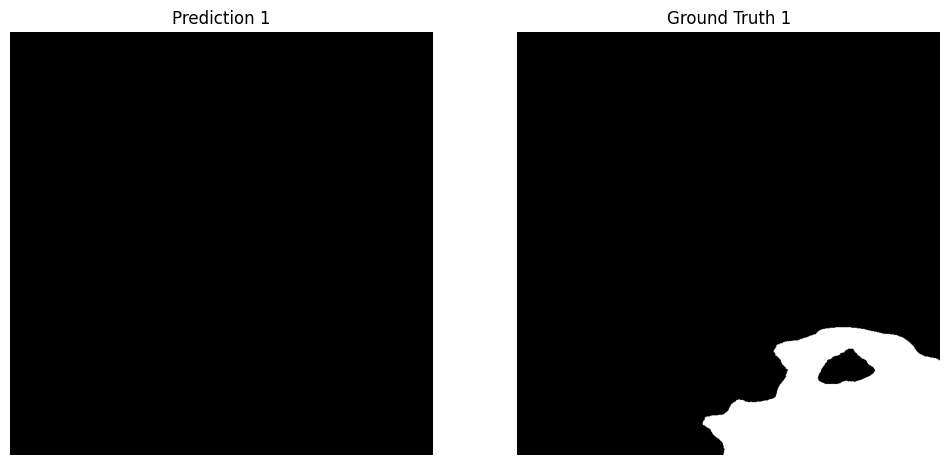

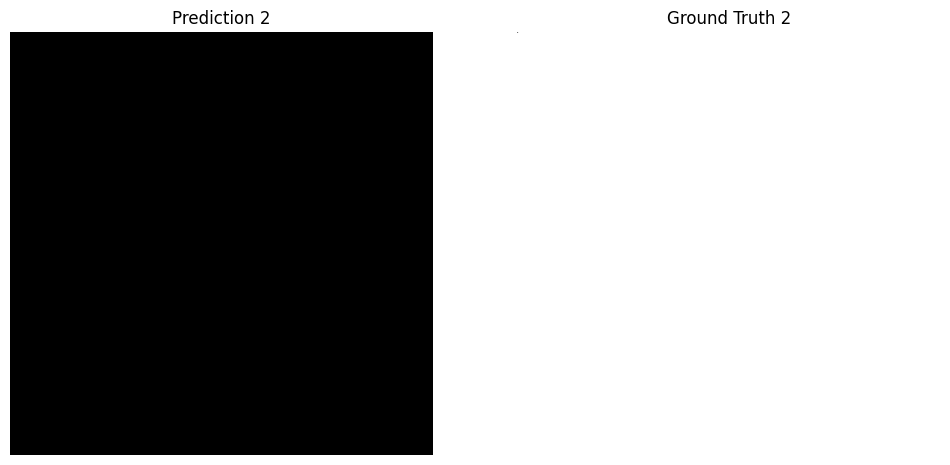

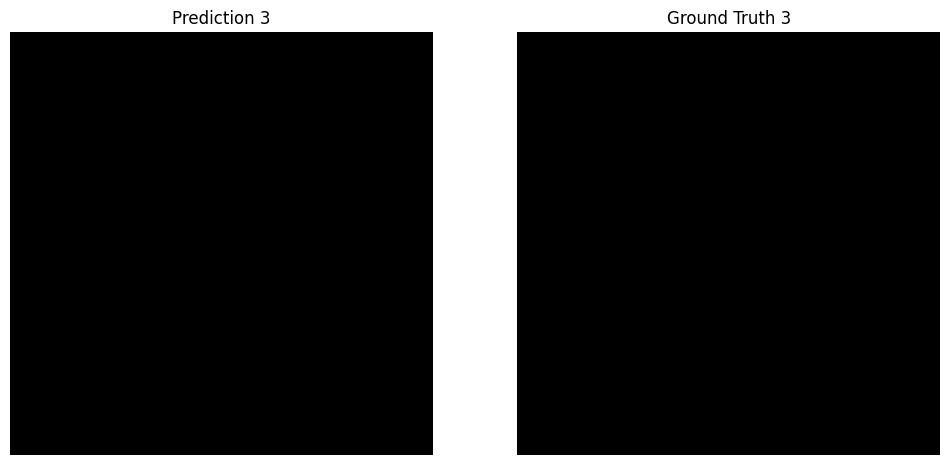

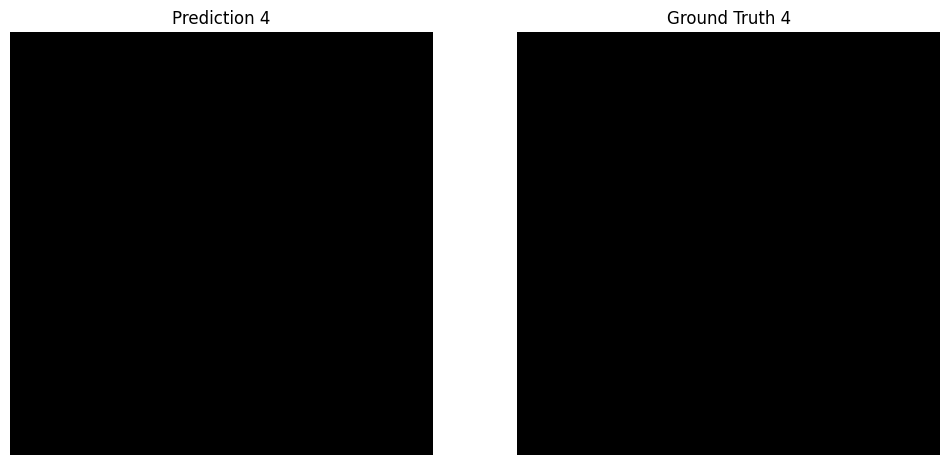

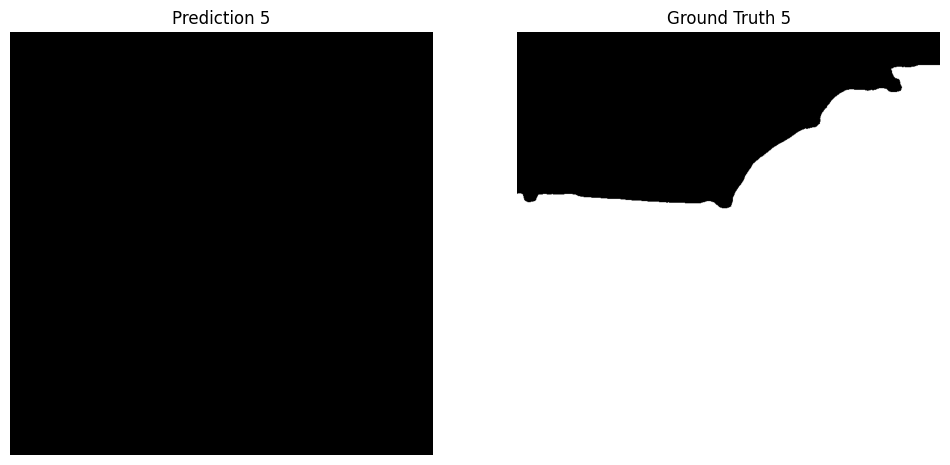

In [80]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_predictions(output_dir, num_images=5):
    # Get all prediction and ground truth image paths
    pred_images = [f for f in os.listdir(output_dir) if 'prediction_' in f]
    gt_images = [f for f in os.listdir(output_dir) if 'ground_truth_' in f]

    # Sort images by the number to display in order
    pred_images.sort()
    gt_images.sort()

    # Plot up to `num_images` pairs of predicted and ground truth masks
    for i in range(min(num_images, len(pred_images))):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Load the prediction and ground truth image
        pred_img = mpimg.imread(os.path.join(output_dir, pred_images[i]))
        gt_img = mpimg.imread(os.path.join(output_dir, gt_images[i]))

        # Display the images
        axes[0].imshow(pred_img, cmap='gray')
        axes[0].set_title(f"Prediction {i+1}")
        axes[0].axis('off')

        axes[1].imshow(gt_img, cmap='gray')
        axes[1].set_title(f"Ground Truth {i+1}")
        axes[1].axis('off')

        plt.show()

# Call the function to visualize predictions
visualize_predictions(output_dir)

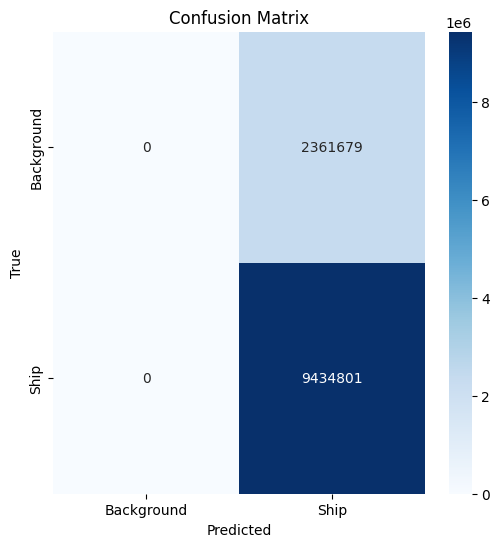

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def compute_confusion_matrix(model, dataloader, device):
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []

    for batch in dataloader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        with torch.no_grad():
            outputs = model(images)
            outputs = (outputs > 0.5).float()  # Binary output

        # Flatten the predictions and true masks for confusion matrix
        all_preds.append(outputs.cpu().numpy().flatten())
        all_labels.append(masks.cpu().numpy().flatten())

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return cm

def plot_confusion_matrix(cm):
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Background", "Ship"], yticklabels=["Background", "Ship"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Compute confusion matrix and plot
cm = compute_confusion_matrix(model, train_loader, DEVICE)
plot_confusion_matrix(cm)


In [82]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(cm):
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]

    # Precision, Recall, F1-score
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Calculate and print metrics
calculate_metrics(cm)


Precision: 0.7998
Recall: 1.0000
F1-Score: 0.8888


### Precision (0.7998):

The model is relatively accurate when it predicts ships. However, there is still room for improvement to avoid some false positives. For example, 20% of the time when the model predicts a ship, it might be wrong.

### Recall (1.0000):

The model is perfect at detecting all ships. It doesn't miss any ship, which is great for tasks where detecting every ship is crucial (e.g., in safety-critical systems). However, this may come at the cost of false positives (as seen in the precision metric).
### F1-Score (0.8888):

The F1-score being high means that the model is a good all-around performer, balancing both precision and recall well. A score of 0.8888 indicates strong performance.